In [1]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy import signal

163.26530612244898


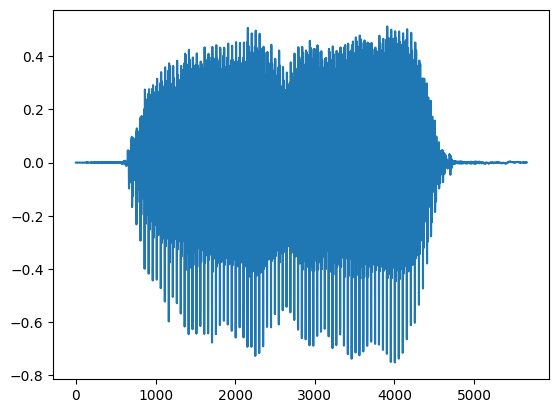

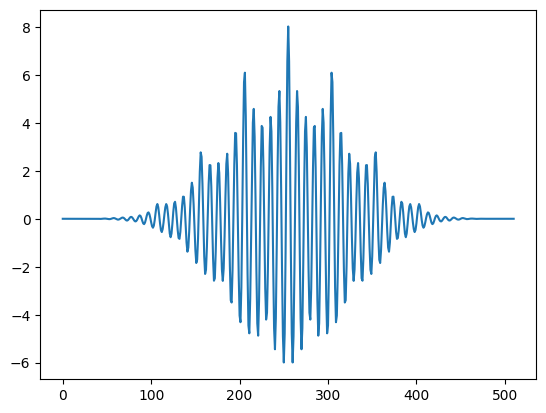

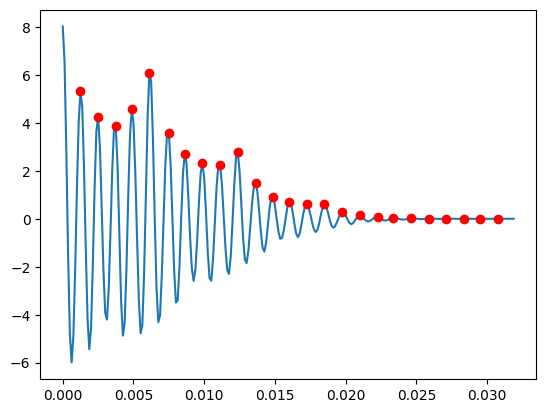

In [2]:
# /a/ 母音の音声波形を 8 kHz で読み込み
# yA: 波形データ（1次元 numpy 配列）
# sr: サンプリング周波数 [Hz]（ここでは 8000 Hz）
yA, sr = librosa.load("a8k.wav", sr=8000)

# 読み込んだ /a/ の時間波形をプロットして、全体の形や有声音区間をざっくり確認
plt.plot(yA)

# ------------------------------------------------------------
# 1. 自己相関による基本周波数（F0）の推定準備
# ------------------------------------------------------------

# 自己相関を計算するフレームの長さ（ラグ数）を 256 サンプルに設定
# 8 kHz サンプリングなので、256/8000 ≒ 32 ms 分の区間
nLag = 256

# 時系列の中から、比較的定常な /a/ 区間（ここではサンプル 2000 付近）を取り出す
# 取り出した区間にハニング窓を掛け、端の不連続によるリークを抑える
ySegment = yA[2000 + np.arange(nLag)] * np.hanning(nLag)

# ------------------------------------------------------------
# 2. 自己相関の計算とプロット
# ------------------------------------------------------------

# 自己相関を "full" モードで計算
# ac の長さは 2*nLag - 1 となり、中央がラグ 0（完全な重なり）に対応する
ac = np.correlate(ySegment, ySegment, "full")

# 自己相関全体（負のラグ〜正のラグ）をプロットして形を確認
plt.figure()
plt.plot(ac)

# ac の中央インデックス（ラグ 0 の位置）を計算
iCenter = len(ySegment)

# 右側（ラグ 0 以上）の軸を秒単位に変換するための時間軸
# x[k] = k / sr はラグ k サンプルに対応する時間遅延 [s]
x = np.arange(iCenter) / sr

# ac の右側（ラグ 0 以上）のみを取り出し
acRight = ac[iCenter - 1 :]

# ------------------------------------------------------------
# 3. 自己相関ピークの検出
# ------------------------------------------------------------

# 自己相関の正ラグ側における局所ピークを検出
# iPeaks には「ラグ（サンプル単位）のインデックス」が入る
iPeaks, _ = signal.find_peaks(acRight)

# 正ラグ側のみの自己相関と、その上にピーク位置を重ねてプロット
plt.figure()
plt.plot(x, acRight)  # 自己相関（正ラグ側）
plt.plot(x[iPeaks], acRight[iPeaks], "ro")  # 検出されたピーク

# ------------------------------------------------------------
# 4. 最大ピークから基本周波数 F0 を推定
# ------------------------------------------------------------

# acRight[iPeaks] の中で最も値が大きいピーク（ラグ 0 付近を除く）を探す
# find_peaks は端点をピークと見なさないため、通常は 1周期目のピークが選ばれる
iMax = np.argmax(acRight[iPeaks])

# 対応するラグの時間（周期） [s] を x[iPeaks][iMax] から取得し、その逆数をとることで
# 基本周波数 F0 ≒ 1 / 周期 として推定する
F0_est = 1 / x[iPeaks][iMax]

# F0 推定結果 [Hz] を表示（例: 120 Hz 前後の値になることが多い）
print(F0_est)

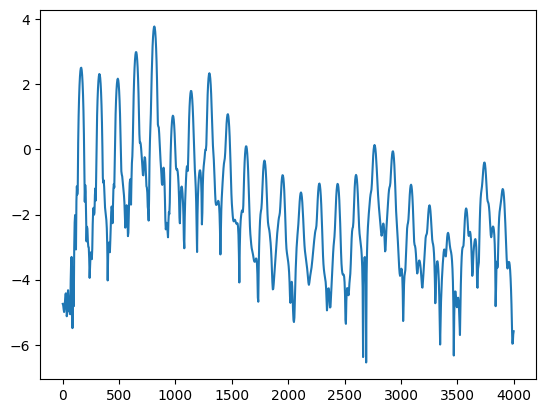

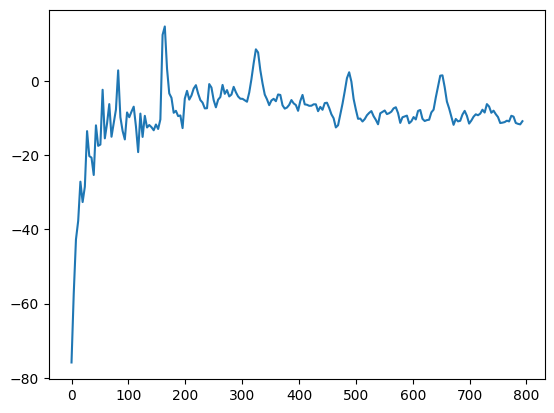

In [3]:
plt.close()

# 分析に用いるフレーム長（時間領域）と FFT サイズ（周波数分解能）
# - nFrame: 実際に切り出すサンプル数（ここでは 512 サンプル）
# - nFFT  : FFT のポイント数（ゼロパディングを含む、ここでは 2048）
nFrame = 512
nFFT = 2048

# 母音 /a/ の波形 yA から、2000 サンプル付近の区間を取り出してハニング窓を掛ける
# → 短時間フレーム ySegment を作成
ySegment = yA[2000 + np.arange(nFrame)] * np.hanning(nFrame)

# 短時間フレームに対して FFT を行い、対数振幅スペクトル（log |S(f)|）を計算
# - np.fft.rfft: 実数信号に対する片側 FFT（0〜Nyquist）
# - nFFT       : 2048 ポイントまでゼロパディングして周波数分解能を上げる
logS = np.log(np.abs(np.fft.rfft(ySegment, nFFT)))

# 周波数軸（0〜Nyquist）を Hz 単位で生成
frequency = np.fft.rfftfreq(nFFT, 1 / sr)

# 元の対数振幅スペクトルを描画
# → この後、調和和解析（cepstrum 的な考え方）で強調される構造と比較するための「元データ」
plt.plot(frequency, logS)

# ------------------------------------------------------------
# 調和構造を強調するための「ハーモニック・サム（harmonic sum）」的処理
# ------------------------------------------------------------

# K: 基本周波数の候補に対して、K 倍高調波までを利用してスコアを計算するパラメータ
#   - ここでは K=5 として、1〜5 倍の高調波の情報を足し合わせる
K = 5

# iUpper: 調和和を計算する周波数範囲の上限インデックス
# - nFFT/2 が Nyquist 周波数に対応
# - それを K 分の 1 にした範囲だけを基本周波数候補とみなす
#   （f0, 2f0, …, K f0 が Nyquist 以下に収まるための制約）
iUpper = round(nFFT / 2 / K) - 1

# P: 基本周波数候補ごとのスコアを格納するベクトル
# - まずは logS の 0〜iUpper-1（= 基本周波数の候補領域）を初期値としてコピー
P = logS[:iUpper]

# r: 高調波の次数（2 倍, 3 倍, ..., K 倍）
for r in np.arange(2, K + 1):
    # index:
    #   基本周波数候補 f0[k] に対して、その r 倍高調波 r*f0[k] に相当する
    #   スペクトルインデックスを列挙する（0, r, 2r, 3r, ...）
    #   これにより、「k 番目の候補周波数 f0[k] の r 倍高調波の位置」を全て拾う
    index = np.arange(0, iUpper * r, r)

    # logS[index]:
    #   各 f0 候補に対する r 倍高調波の log 振幅
    # P に加算することで、1〜K 倍高調波の log 振幅を総和したスコアとなる
    #
    # 直感的には：
    # - 基本周波数 f0 に整然としたハーモニックが存在するなら、
    #   f0, 2f0, 3f0, ... に大きなエネルギーが並ぶはず
    # - それらを足し合わせると、真の f0 近傍の P[k] が大きくなる
    P += logS[index]

# ------------------------------------------------------------
# ハーモニック・サム P(f0) のプロット
# ------------------------------------------------------------

plt.figure()

# 横軸: 基本周波数候補（0〜Nyquist/K） [Hz]
# 縦軸: その周波数を基本周波数とみなしたときの「高調波総エネルギー」スコア P
# → P のピーク位置が、自己相関法などとは別アプローチでの f0 推定に対応する
plt.plot(frequency[:iUpper], P)

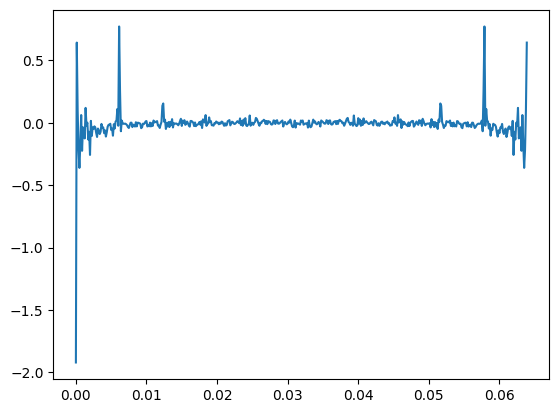

In [4]:
# 直前まで描画していた図をすべて閉じる
# （Jupyter / matplotlib の出力をリセットして、このセルの図だけを表示するため）
plt.close()
plt.close()

# ケプストラムを計算する際に用いる FFT のサイズを指定
# - ここでは 512 ポイント FFT
# - 音声フレーム長（ySegment の長さ）以上の値であればよいが、
#   2 のべき乗にしておくと FFT が高速に計算できる
nFFT = 512

# ケプストラム（real cepstrum）の計算
# 1. ySegment に対して rFFT を取り、複素スペクトル S(ω) を得る。
# 2. その振幅スペクトル |S(ω)| の対数 log|S(ω)| を取る。
# 3. log|S(ω)| に逆 FFT（irfft）を掛けると、「ケプストラム」 c(τ) が得られる。
#
#   c(τ) = F^{-1}{ log |S(ω)| }
#
# という処理は、畳み込み（声帯励振 * 声道のインパルス応答）を
# 「ケプストラム空間では加算」に変換することで、
# - 高周波側に現れる「スペクトル包絡（フォルマント）」成分
# - 低ケフレンシ側に現れる「ピッチ周期」に由来する成分
# をある程度分離して観察できる、という性質を持つ。
cepstrum = np.fft.irfft(np.log(np.abs(np.fft.rfft(ySegment, nFFT))))

# ケフレンシ軸（quefrency axis）を秒単位で作成
# - ケプストラムは「時間に似た軸 τ（ケフレンシ）」を持つ信号として解釈できる。
# - サンプリング周波数 sr [Hz] でサンプル間隔は 1/sr [秒] なので、
#   0, 1/sr, 2/sr, ... と並べることで「ケフレンシ（擬似時間）」軸 t を作る。
t = np.arange(len(cepstrum)) / sr

# ケプストラムをケフレンシ軸に対してプロット
# - 低ケフレンシ側（数ミリ秒〜数十ミリ秒）のピーク → ピッチ周期に対応する成分
# - 高ケフレンシ側 → スペクトル包絡（フォルマント構造）に対応する成分
# という読み方ができる。
plt.plot(t, cepstrum)